# Predictive Supermark Pricing Model

## Objective:

Correctly forecast and predict demand for products based on several factors.

Dataset Breakdown:
"country": Name of the country
"child_mort": Death of children under 5 years of age per 1000 live births
"exports": Exports of goods and services per capita. Given as %age of the GDP per capita
"health": Total health spending per capita. Given as %age of GDP per capita
"imports": Imports of goods and services per capita. Given as %age of the GDP per capita
"income": Net income per person
"inflation": The measurement of the annual growth rate of the Total GDP
"life_expec": The average number of years a new born child would live if the current mortality patterns are to remain the same
"total_fer": The number of children that would be born to each woman if the current age-fertility rates remain the same.
"gdpp": The GDP per capita. Calculated as the Total GDP divided by the total population.

## Importing Libraries

In [136]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns


# feature engineering
from sklearn.model_selection import train_test_split #splitting data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize # standarizing /scaling data
from statsmodels.stats.outliers_influence import variance_inflation_factor # multicollinearity

# model


## Exploring Data

### Loading Data

In [76]:
df = pd.read_csv('../data/supermarket_sales.csv')
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [77]:
# no missing values
df.isna().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

Exploring the datatypes for each column. We might need to change the types for some columns to better represent the column. In addition, these many categorical, object type columns will need to be turned into dummy columns.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

Now we're taking a look at the spread of the dataset. This can tell us if we need to scale or normalize our data later down the line.

In [79]:
df.describe()


,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


In this grid, we see that Unit price and Quanity are normally distributed.
The remaining 4 columns are right skewed, suggesting we use a log transformation.
We'll save these transformation for a later step before traning our model.

IndexError: index 3 is out of bounds for axis 0 with size 3

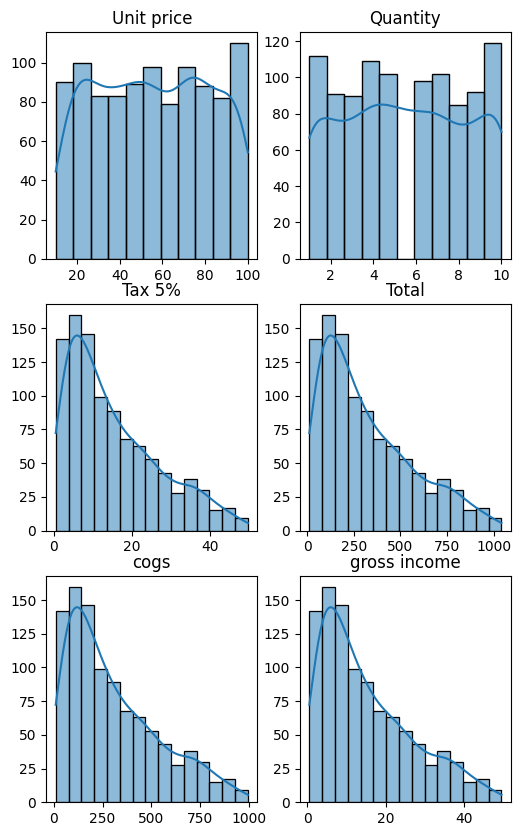

In [80]:
numerical_features = ['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs', 'gross income', 'Rating']
numerical_df = df[numerical_features]

fig, axes = plt.subplots(3, 2, figsize=(6, 10))

# Plot histograms for each numerical feature in the 3x2 grid
for i, column in enumerate(numerical_df.columns):
    sns.histplot(numerical_df[column], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{column}')
    axes[i//2, i%2].set_xlabel('')
    axes[i//2, i%2].set_ylabel('')
    
plt.tight_layout()
plt.show()

What type of products are each gender most likely to buy?

<function matplotlib.pyplot.show(close=None, block=None)>

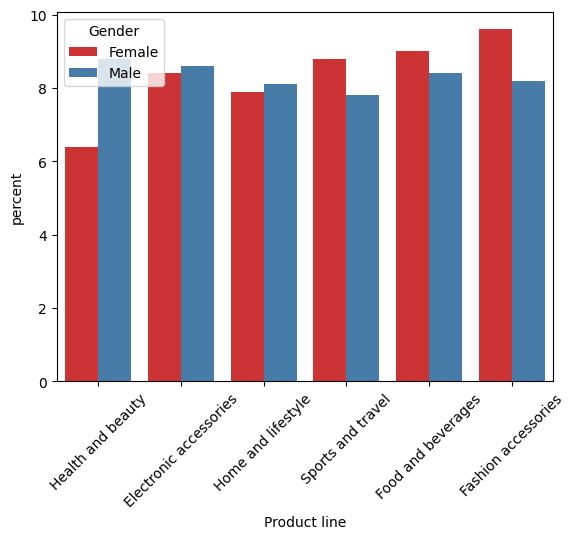

In [ ]:
sns.countplot(x='Product line', data=df, hue='Gender', palette='Set1', stat='percent', orient='h', gap=2)
plt.xticks(rotation=45) 
plt.show()

# Feature Engineering

In [83]:
# dropping invoice id, as we have no use for it in this scenario,
df.drop('Invoice ID', axis=1, inplace=True)
#dropping 'gross margin percentage' as the value is the same for every row
df.drop('gross margin percentage', axis=1, inplace=True)

In [ ]:
df['Time'].value_counts()

Time
19:48    7
14:42    7
17:38    6
17:16    5
11:40    5
        ..
13:26    1
11:17    1
14:57    1
17:53    1
19:12    1
Name: count, Length: 506, dtype: int64

In [ ]:
# checking for class imbalance
categorical_columns = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']


imbalanced_columns = []
for column in categorical_columns:
    value_counts = df[column].value_counts(normalize=True)
    min_frequency = value_counts.min()
    if min_frequency < 0.1: # using 10% as the threshold
        imbalanced_columns.append(column)

if not imbalanced_columns:
    print("No class imbalances detected.")
else:
    print(f"Class imbalances detected in columns: {', '.join(imbalanced_columns)}")


No class imbalances detected.


In [85]:
# exploring multicollinearity

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

Running the function on the original numerical features yeilds very high multicollinearity. This makes sense and is okay since certain columns are very closely related. For example, you would expect the 'Total' to be related to the 'Unit price' and 'Quanity'. We can reduce this multicollinearity and improve our future model scores by getting rid of some of these related columns, since the data can be infered from the other columns.

In [86]:
calc_vif(df[numerical_features])

c:\Users\o\Documents\code\Dynamic_Supermarket_Pricing\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,Unit price,13.295384
1,Quantity,13.789474
2,Tax 5%,inf
3,Total,inf
4,cogs,inf
5,gross income,inf
6,Rating,10.921189


Vola! The scores are much lower and much improved!

In [88]:
# modified numberical features to reduce VIF
numerical_features_1 = ['Unit price', 'gross income', 'Rating']

calc_vif(df[numerical_features_1])


,variables,VIF
0,Unit price,8.058448
1,gross income,4.562741
2,Rating,4.300001


Let's create a new dataframe with our selected columns. We will be doing further analysis on this new dataframe to see what additional improvements we can make.

In [160]:
selected_features = numerical_features_1 + categorical_columns

filtered_df = df[selected_features].copy()

filtered_df.head()

,Unit price,gross income,Rating,Branch,City,Customer type,Gender,Product line,Payment
0,74.69,26.1415,9.1,A,Yangon,Member,Female,Health and beauty,Ewallet
1,15.28,3.8200,9.6,C,Naypyitaw,Normal,Female,Electronic accessories,Cash
2,46.33,16.2155,7.4,A,Yangon,Normal,Male,Home and lifestyle,Credit card
3,58.22,23.2880,8.4,A,Yangon,Member,Male,Health and beauty,Ewallet
4,86.31,30.2085,5.3,A,Yangon,Normal,Male,Sports and travel,Ewallet


Let's investigate what a heatmap shows for the correlation between the columns of our new dataframe.

While we get high correlation scores between the 'Unit price' and the 'gross income', it should be okay to include both features when training our model. This is because for this problem, we will be using 'gross income' as the target varible. 'Unit price' is important further down the line for the functionality of the end project.

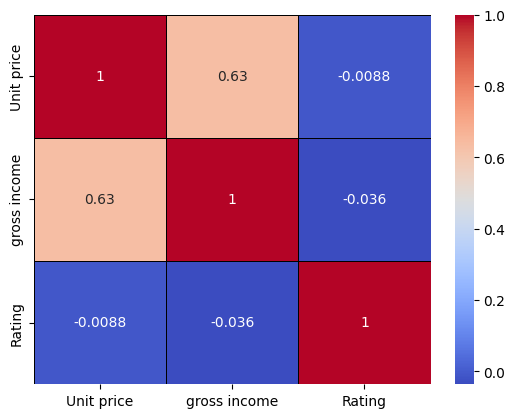

In [161]:
# checking for multicollinearity
sns.heatmap(
    filtered_df.select_dtypes(include='float').corr(),annot=True,
    linecolor='black',linewidths=.5,
    cmap='coolwarm')

plt.show()

### Scaling Data

Machine learning models do not understand the units of the values of the features. They treat the inputs as a simple number without understanding the true meaning of that value. Thus, it becomes necessary to scale the data.

There are two choices to select from when scaling data: Normalizing and Standardizing

- Normalizing occurs when data is normally distributed
- Standarzdizing usually happens when data is normally distributed, just the values are on different scales than other features

Since our data isn't normally distributed, we will opted for normalization.

In [162]:
# saving and dropping the target feature
y = filtered_df['gross income']
filtered_df.drop('gross income', axis=1, inplace=True)

In [163]:
# normalization
numerical_features =  ['Unit price', 'Rating']
d = normalize(filtered_df[numerical_features])

minmaxscale = MinMaxScaler()

d = minmaxscale.fit_transform(d)
scaled_df = pd.DataFrame(d, columns=numerical_features)
scaled_df.head()

,Unit price,Rating
0,0.975688,0.125259
1,0.431402,0.765815
2,0.956378,0.182578
3,0.964839,0.159323
4,0.996057,0.032301


Creating dummy columns for our categorical features

In [168]:
categorical_df = pd.DataFrame()
for col in categorical_columns:
    dummies = pd.get_dummies(filtered_df[col], prefix=col)
    categorical_df = pd.concat([categorical_df, dummies], axis=1)
categorical_df.head()

,Branch_A,Branch_B,Branch_C,City_Mandalay,City_Naypyitaw,City_Yangon,Customer type_Member,Customer type_Normal,Gender_Female,Gender_Male,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,True,False,False,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True
1,False,False,True,False,True,False,False,True,True,False,True,False,False,False,False,False,True,False,False
2,True,False,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,True,False
3,True,False,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,True
4,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True,False,False,True


In [172]:
# combining the dataframes
final_df = pd.concat([scaled_df, categorical_df], axis=1)
final_df.head()

,Unit price,Rating,Branch_A,Branch_B,Branch_C,City_Mandalay,City_Naypyitaw,City_Yangon,Customer type_Member,Customer type_Normal,...,Gender_Male,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,0.975688,0.125259,True,False,False,False,False,True,True,False,...,False,False,False,False,True,False,False,False,False,True
1,0.431402,0.765815,False,False,True,False,True,False,False,True,...,False,True,False,False,False,False,False,True,False,False
2,0.956378,0.182578,True,False,False,False,False,True,False,True,...,True,False,False,False,False,True,False,False,True,False
3,0.964839,0.159323,True,False,False,False,False,True,True,False,...,True,False,False,False,True,False,False,False,False,True
4,0.996057,0.032301,True,False,False,False,False,True,False,True,...,True,False,False,False,False,False,True,False,False,True


# Modeling

In [174]:
from sklearn.model_selection import train_test_split
X = final_df.values
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

In [175]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 21), (300, 21), (700,), (300,))

In [176]:
# initializing the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [181]:
# creating the predictions
y_pred = model.predict(X_test)

In [178]:
model.intercept_

391749645770620.6

# Metrics

In [182]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


In [183]:
mean_absolute_error(y_test,y_pred)

7.94657

In [184]:
mean_absolute_percentage_error(y_test,y_pred)

1.063595097000829

In [185]:
mean_squared_error(y_test,y_pred)

102.67461260666667

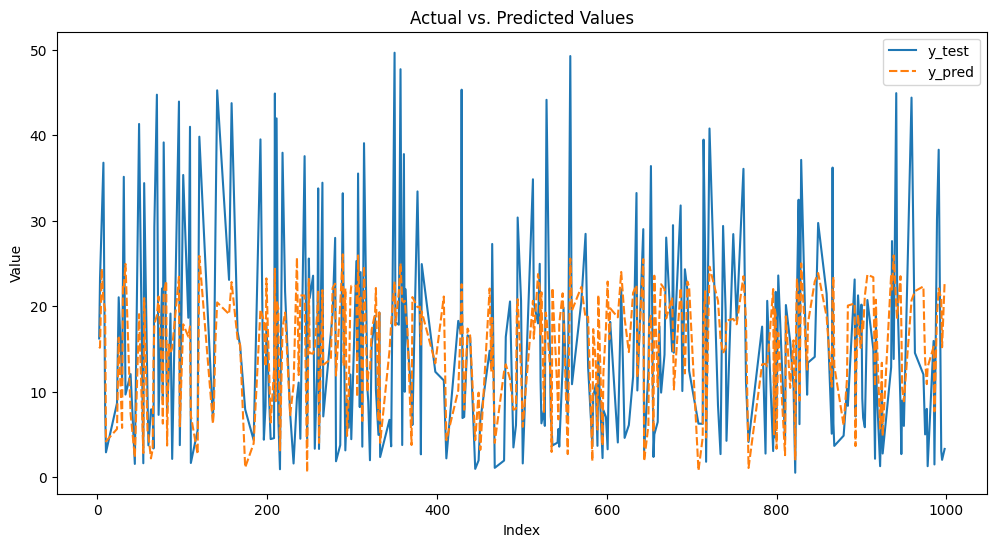

In [187]:
comparison_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Create a line plot using Seaborn
plt.figure(figsize=(12, 6))

sns.lineplot(data=comparison_df)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.show()